In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import string
import re
import pymorphy2
from collections import OrderedDict
from nltk.probability import FreqDist
from nltk.stem.snowball import SnowballStemmer 
from stop_words import get_stop_words
from ipywidgets import IntProgress
from IPython.display import display

Функция прогресса итерации:

In [169]:
def log_progress(sequence, every=1):
    progress = IntProgress(min=0, max=len(sequence), value=0)
    display(progress)
    
    for index, record in enumerate(sequence):
        if index % every == 0:
            progress.value = index
        yield record 

Фильтр по iot категориям:

In [170]:
iot_class = True

Гиперпараметры:

In [171]:
min_word_length = 2
freq_min = 0.01

Читаем директорию с файлами каталога:

In [172]:
list_of_files = os.listdir('data/top_ym/')
files_num = len(list_of_files) 

Выбор необходимых атрибутов:

In [173]:
market_features = ['Категория', 'Производитель', 'Название модели']

Читаем файлы с необходимыми атрибутами в один фрейм:

In [174]:
df = pd.DataFrame()
for item in log_progress(list_of_files, every=1):      
    df_file = pd.read_csv(('data/top_ym/' + str(item)), delimiter=';', encoding='windows-1251', usecols=market_features)
    df = pd.concat([df, df_file], axis=0)

IntProgress(value=0, max=313)

Записываем фрейм в csv файл:

In [175]:
df.to_csv('data/market_dirty.csv', index=False)

Переименовываем столбцы:

In [176]:
df = df.rename(columns={'Категория': 'class_m', 'Производитель': 'ven_m', 'Название модели': 'model_m'})

Число записей:

In [177]:
dim_before = int(df.shape[0])
print('Число записей:', int(df.shape[0]))

Число записей: 3421187


Статистики по распределению числа слов в наименовании модели:

In [178]:
print('Медиана числа слов:', round(df['model_m'].str.split().apply(len).mean()))
print('Минимум числа слов:', round(df['model_m'].str.split().apply(len).min()))
print('Максимум числа слов:', round(df['model_m'].str.split().apply(len).max()))

Медиана числа слов: 3
Минимум числа слов: 1
Максимум числа слов: 24


Показываем пропуски в относительных долях:

In [179]:
print('Число нулей для всех признаков:', dict(round(df.isnull().sum()/len(df), 2)))

Число нулей для всех признаков: {'class_m': 0.0, 'ven_m': 0.0, 'model_m': 0.0}


Показываем пропуски в абсолютных значения:

In [180]:
print('Число нулей для всех признаков:', dict(df.isnull().sum()))

Число нулей для всех признаков: {'class_m': 0, 'ven_m': 0, 'model_m': 0}


Сброс записей с пропущенными значениями:

In [181]:
df.dropna(how='any', axis=0, inplace=True)

Удаление пунктуации из строковых атрибутов:

In [182]:
for item in list(string.punctuation): 
    df[['class_m', 'model_m']] = df[['class_m', 'model_m']].applymap(lambda x: x.replace(item, ' '))

Убираем пробелы и приводим к нижнему регистру:

In [183]:
df = df.applymap(lambda x: re.sub(' +', ' ', x) if isinstance(x, str) else x)
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

Сброс дубликатов:

In [184]:
df.drop_duplicates(inplace=True, keep='first', subset=['class_m', 'ven_m', 'model_m'])

Преобразование типов:

In [185]:
df = df.astype({'class_m': 'str', 'ven_m': 'str', 'model_m': 'str'})

Выводим число нулей:

In [186]:
print('Число нулей для всех признаков:', dict(df.isnull().sum()))

Число нулей для всех признаков: {'class_m': 0, 'ven_m': 0, 'model_m': 0}


Записываем категории в filter/classes.txt:

In [187]:
with open('filter/classes.txt', 'w') as f:
    f.writelines('%s\n' % item for item in list(set(df['class_m'])))        

На основе файла составляем список исключений без sim. Записываем в except_class.txt. Читаем исключения из файла:

In [188]:
exceptions = []
with io.open('filter/except_class.txt', 'r', newline=None, encoding='utf-8') as file:
    for item in file:
        item = item.replace('\n', '') 
        exceptions.append(item)

Оставляем категории товаров, которых нет в списке исключений:

In [189]:
if iot_class is True:
    df = df[~df['class_m'].isin(exceptions)] 

Удаляем дублирующиеся слова в названии модели:

In [190]:
df['model_m'] = df['model_m'].apply(lambda x: ' '.join(OrderedDict.fromkeys(x.split())))

Удаляем производителей из названий модели:

In [191]:
for item in log_progress(list(set(df['ven_m'])), every=1):
    df['model_m'] = df['model_m'].apply(lambda x: x.replace(item, ''))

IntProgress(value=0, max=351)

Составляем список стоп слов русского словаря с фильтром по длине: 

In [192]:
stop_words_ru = [item for item in get_stop_words('russian') if len(item) > min_word_length]

Удаляем стоп слова в названии модели:

In [193]:
for stop in log_progress(stop_words_ru, every=1):
    remove_stops = (lambda x: ' '.join([item for item in x.split() if item != stop]))
    df['model_m'] = df['model_m'].apply(remove_stops)    

IntProgress(value=0, max=375)

Создаем вектор ключевых слов по названиям категорий:

In [194]:
keys = " ".join(list(set(df['class_m'])))
keys = list(set(keys.split()))
keys = [x for x in keys if len(x) > min_word_length]

Выделяем основы слов:

In [195]:
morph = pymorphy2.MorphAnalyzer()
stemmer = SnowballStemmer("russian") 
keys = [morph.parse(item)[0].normal_form for item in keys]
keys = [stemmer.stem(item) for item in keys]

Оставляем слова в наименованиях модели, которые не содержат основы: 

In [196]:
for key in keys:
    remove_keys = (lambda x: ' '.join([item for item in x.split() if (key not in item)]))
    df['model_m'] = df['model_m'].apply(remove_keys)

Создаем словарь из наименований моделей:

In [197]:
text = list(' '.join(list(df['model_m'])).split())  

Оставляем только русские слова в словаре:

In [198]:
text = [re.sub('[^А-Яа-я]', '', x.strip()) for x in text]
text = [x for x in text if len(x) > min_word_length]

Составляем функцию распределения слов по частоте:

In [199]:
model_dict = list(FreqDist(text).most_common(len(text)))
model_dict = [(x, y/len(text)) for (x,y) in model_dict]

Выводим СЧХ на экран:

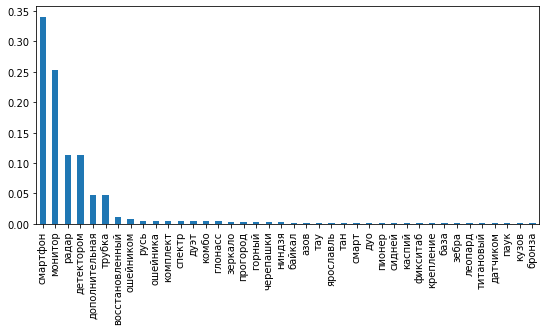

In [200]:
df_model_dict = pd.DataFrame(model_dict, columns=['Словарь', 'Частота'])
fig = df_model_dict.plot(kind='bar', x='Словарь', legend=False, figsize=(9,4))
fig.xaxis.set_label_text("")
plt.show()

Оставляем слова в словаре с частотой более, чем freq_min:

In [201]:
model_dict = [(x,y) for (x,y) in model_dict if float(y) > freq_min]

Приводим слова в словаре к нормальной форме и выделяем основу:

In [202]:
model_dict = [x for (x,y) in model_dict]
model_dict = [morph.parse(item)[0].normal_form for item in model_dict]
model_dict = [stemmer.stem(item) for item in model_dict]

Если в слове из наименования модели присутствует 'основа' - генератор, то слово удаляется: 

In [203]:
for word in model_dict:
    remove_keys = (lambda x: ' '.join([item for item in x.split() if (word not in item)]))
    df['model_m'] = df['model_m'].apply(remove_keys)

Удаляем характеристику объема памяти 'число + GB': она не влияет на tac номер:

In [204]:
df['model_m'] = df['model_m'].apply(lambda x: re.sub(r'\d+gb', '', x))    

Удаляем записи с пропущенными значениями:

In [205]:
df = df.apply(lambda x: x.str.strip() if isinstance(x, str) else x).replace('', np.nan)
df = df.dropna(how='any', axis=0)

Статистики по распределению числа слов в наименовании модели:

In [206]:
print('Медиана числа слов:', round(df['model_m'].str.split().apply(len).mean()))
print('Минимум числа слов:', round(df['model_m'].str.split().apply(len).min()))
print('Максимум числа слов:', round(df['model_m'].str.split().apply(len).max()))

Медиана числа слов: 2
Минимум числа слов: 1
Максимум числа слов: 11


Число записей:

In [207]:
dim_after = int(df.shape[0])
print('Число записей:', int(df.shape[0]))

Число записей: 7294


Компрессия по числу записей:

In [208]:
print('Компрессия по числу записей:', round(dim_before/dim_after))

Компрессия по числу записей: 469


Описание фрейма:

In [209]:
df.describe()[:2][:]

,class_m,ven_m,model_m
count,7294,7294,7294
unique,11,349,6265


Выводим случайный сэмпл:

In [210]:
df.sample(n=10)

,class_m,ven_m,model_m
10116,gps навигаторы,garmin,nuvi 2589 lmt
12411,умные часы и браслеты,кнопка жизни,ocean
9979,gps навигаторы,garmin,16 lvs
250,автомагнитолы,intro,ahr 2481 sl
10544,планшеты,digma,idxd8 3g
9165,видеорегистраторы,parkcity,d hd 500
3705,телевизоры,bbk,43lex 5043 ft2c
9664,планшеты,apple,ipad mini 2 wi fi cellular
6,автомагнитолы,pioneer,deh 80prs
5882,проводные телефоны,палиха,п 750


Записываем csv в директорию:

In [211]:
df.to_csv('data/market_clean.csv', index=False)